Smoothed NDVI

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from p_drought_indices.functions.ndvi_functions import get_irradiances, compute_ndvi_corr

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

ndvi_dir = config_file['NDVI']['ndvi_prep']
    
new_dir = os.path.join(ndvi_dir,"new_process")
list_files_2 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]

ds = xr.open_dataset(list_files_2[1000])

msg_type = ds.attrs['EPCT_product_name'][:4]

girradiance_vis6, irradiance_vis8 = get_irradiances(msg_type)

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

# Open the NetCDF file with xarray
ds = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))
ds_ndvi = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_prep'], 'final_ndvi.nc'))
ds_smoot = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))
vci = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'vci_1D.nc'))

In [ ]:
import pandas as pd 
from datetime import timedelta

from p_drought_indices.analysis.visualizations.viz_series import plot_ndvi_days

plot_ndvi_days(ds_smoot,
               start_day="2010-01-01",
                num_timesteps=15)

In [ ]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing, get_lat_lon_window
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import pickle

CONFIG_PATH= "../config.yaml"

time_end = "2019-12-31"
time_start = "2005-01-01"


def spi_ndvi_convlstm():
    config_file = load_config(CONFIG_PATH=CONFIG_PATH)

    # Open the NetCDF file with xarray
    dataset = prepare(xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))).sel(time=slice(time_start,time_end))

    prod = "ERA5"
    late = 90

    path = config_file['SPI']['ERA5']['path']
    file = "era5_land_merged.nc" #f"ERA5_spi_gamma_{late}.nc"
    precp_ds = xr.open_dataset(os.path.join(path, file))
    var_target = "spi_gamma_{}".format(late)
    print(f"The {prod} raster has spatial dimensions:", precp_ds.rio.resolution())

    #### training parameters
    train_split = 0.8
    batch_size=4
    dim=64
    preprocess_type="None"

    ### Load dataset
    file_path = os.path.join(config_file["DEFAULT"]["data"],'preprocessed_data.pkl')
    if os.path.exists(file_path):
        print("The file exists. Proceeding with the analysis")
        with open(file_path, 'rb') as file:
            train_data, test_data, train_label, test_label = pickle.load(file)
    else:
        print("The file does not exist. Proceeding with preprocessing")
        idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)
        sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
            .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))
        ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})

        

        train_data, test_data, train_label, test_label = CNN_preprocessing(ds, sub_precp, var_origin="ndvi", var_target=var_target, preprocess_type=preprocess_type,  split=train_split)
        # Save the image data using pickle
        with open(file_path, 'wb') as file:
            pickle.dump((train_data, test_data, train_label, test_label), file)
        print("Data written to pickle file")

    # create a CustomDataset object using the reshaped input data
    train_dataset = CustomDataset(train_data, train_label)
    test_dataset = CustomDataset(test_data, test_label)
    
    # create a DataLoader object that uses the dataset
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    
    ### check shape of data
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    
    
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())


    #### Start training

    from p_drought_indices.configs.config_3x3_16_3x3_32_3x3_64 import config
    from torch.nn import MSELoss
    import matplotlib.pyplot as plt
    from p_drought_indices.analysis.DeepLearning.ConvLSTM import ConvLSTM, train_loop, valid_loop, build_logging
    import numpy as np
    
    name = '3x3_16_3x3_32_3x3_64'
    
    logger = build_logging(config)
    model = ConvLSTM(config).to(config.device)
    #criterion = CrossEntropyLoss().to(config.device)
    #criterion = torch.nn.MSELoss().to(config.device)
    criterion = MSELoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_records, valid_records, test_records = [], [], []
    for epoch in range(config.epochs):
        epoch_records = train_loop(config, logger, epoch, model, train_dataloader, criterion, optimizer)
        train_records.append(np.mean(epoch_records['loss']))
        epoch_records = valid_loop(config, logger, epoch, model, test_dataloader, criterion)
        valid_records.append(np.mean(epoch_records['loss']))
        plt.plot(range(epoch + 1), train_records, label='train')
        plt.plot(range(epoch + 1), valid_records, label='valid')
        plt.legend()
        plt.savefig(os.path.join(config.output_dir, '{m}_{n}.png'.format(n=name, m=preprocess_type)))
        plt.close()
    

In [ ]:
from p_drought_indices.functions.function_clns import load_config
from p_drought_indices.analysis.visualizations.viz_vci_spi import plot_veg_event
import os
import xarray as xr
CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)

path = config["PRECIP"]["ERA5_land"]["path"]
output_dir = os.path.join(path,  "graph_net/predicted_data")

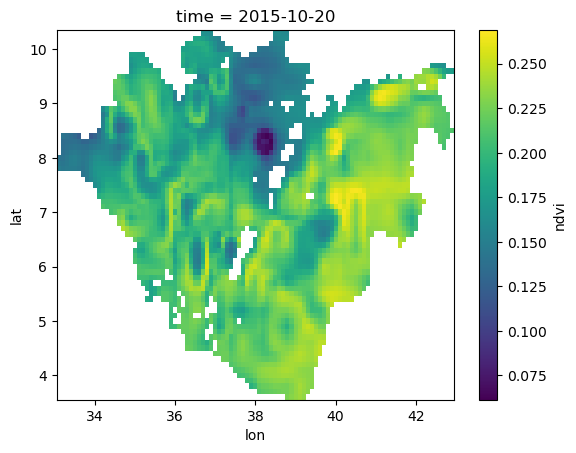

In [ ]:
ds = xr.open_dataset(os.path.join(output_dir, "predicted_ndvi_1.nc"))
ds.isel(time=0)["ndvi"].plot()

days are 366
Calculating the full year for boxplot
The days are 366
days are 365
For year 2017 obtaining only months 1 to 5 for boxplot


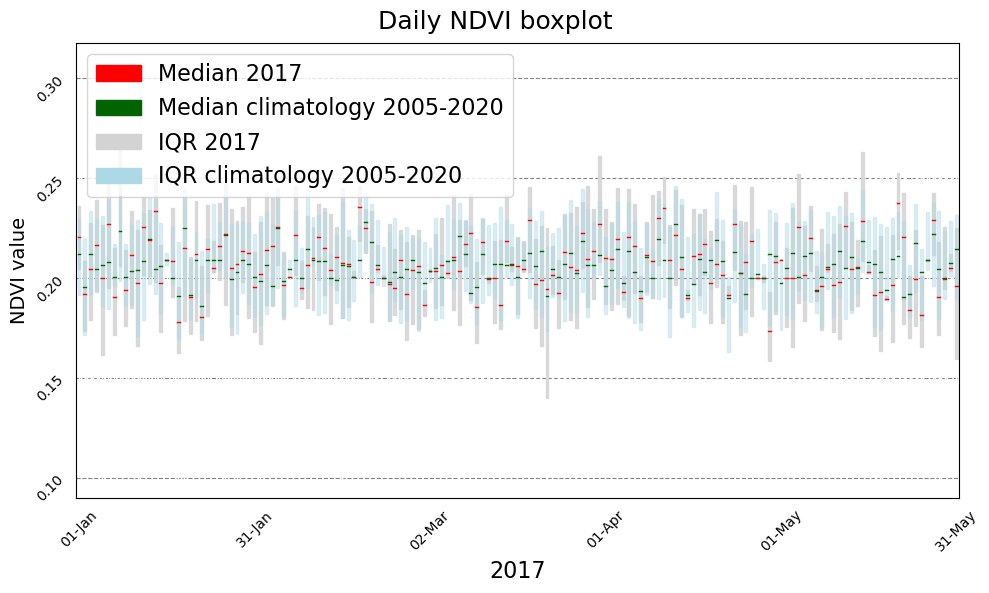

In [84]:
months = [i for i in np.arange(1,6)]
plot_veg_event(ds,year=2017, months=months)

In [10]:
from typing import Union
import geopandas as gpd
import numpy as np


def subsetting_plot(CONFIG_PATH:str, original_matrix:np.array, 
                        countries:Union[list, None] = ['Ethiopia','Kenya', 'Somalia'], 
                        regions: Union[list, None] = None):
    
    config = load_config(CONFIG_PATH)
    if regions is None and countries is None:
        raise ValueError("You must specify either a list of countries or regions")
    if regions is not None and countries is not None:
        raise ValueError("You must specify either country or regions list, not both")
    if countries is not None:
        shapefile_path = config['SHAPE']['africa']
        column = "ADM0_NAME"
        location =countries
    else:
        shapefile_path = config['SHAPE']['ethiopia']
        column = "REGIONNAME"
        location=regions

    gdf = gpd.read_file(shapefile_path)
    subset = gdf[gdf[column].isin(location)]

    bbox = subset.total_bounds

    # Define the cropping coordinates
    minx, miny, maxx, maxy = bbox

    # Determine the row and column indices corresponding to the bounding box
    # Adjust these indices as needed depending on your data format and coordinate system
    min_row, min_col = int(miny), int(minx)
    max_row, max_col = int(maxy), int(maxx)

    # Crop the original matrix to the bounding box
    return original_matrix[min_row:max_row, min_col:max_col]

In [ ]:
class Args:
    def __init__(self):
        self.device = 'cuda'
        self.adjtype = 'doubletransition'
        self.gcn_bool = False
        self.aptonly = False
        self.addaptadj = False
        self.randomadj = False
        self.nhid = 32
        self.in_dim = 1
        self.batch_size = config_file["GWNET"]["batch_size"]
        self.learning_rate = 0.001
        self.dropout = 0.3
        self.weight_decay = 0.0001
        self.print_every = 50
        self.expid = 1
        self.latency = 90
        self.spi = False
        self.precp_product = product
        self.forecast = 12
        self.seq_length = 12
        self.country = ["Kenya", "Ethiopia", "Somalia"]
        self.region = None
        self.dim = config_file["GWNET"]["pixels"]
        self.convlstm = False

# Create an instance of the Args class
args = Args()

from analysis.deep_learning.GWNET.pipeline_gwnet import load_adj, MetricsRecorder, trainer,get_dataloader, data_preparation
from analysis.deep_learning.GWNET.predictions_gwnet import get_predicted_dataset
path = config_file["PRECIP"]["ERA5_land"]["path"]
args.output_dir = os.path.join(path,  "graph_net")
checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.forecast}")
model_path = [os.path.join(checkp_path, f) for f in os.listdir(checkp_path) if "best" in f][0]

sub_precp, ds =  data_preparation(args, CONFIG_PATH, precp_dataset=args.precp_product)
dataloader, num_nodes, x_df = get_dataloader(args, CONFIG_PATH, sub_precp, ds, check_matrix=True)

In [18]:
def test(model, loss, test_loader, args):
    """
    Test logic for the GWN model. Makes predictions on the input supplied, calculates loss(MSE) without updating weights.
    Parameters:
        test_loader - Instance of DataLoader which performs preprocessing operations and an iterator to iterate through the data
        args - Parser of parameter arguments
    Returns:
        test_loss/trainLoader.num_batch - returns the validation loss(MSE) across the batches fed into it by the DataLoader
        predictions - returns a list of the predictions made by the GWN model on the test set
        targets - returns a list of the test inputs fed into the GWN model
    """
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        test_loss = 0
        for iter, (x, y) in enumerate(test_loader.get_iterator()):
            x = torch.Tensor(x).to(args.device)
            x = x.transpose(1, 3)
            y = torch.Tensor(y).to(args.device)
            y = y.transpose(1, 3)
            input = torch.nn.functional.pad(x, (1, 0, 0, 0))
            output = model(input)
            output = output.transpose(1, 3)
            real = torch.unsqueeze(y[:, 0, :, :], dim=1)
            loss = loss(output, real)
            test_loss += loss
            predictions.append(output.cpu().detach().numpy())
            targets.append(real.cpu().detach().numpy())
        return (test_loss / test_loader.num_batch).item(), predictions, targets

In [ ]:
dates = x_df.index
cols = x_df.columns
sub_cols = [ (i[1], i[2]) for i in cols]
epochs = config_file["GWNET"]["epochs"]
dim = args.dim

device = torch.device(args.device)
adj_path = os.path.join(os.path.join(args.output_dir,  "adjacency_matrix"), f"{args.precp_product}_{args.dim}_adj_dist.pkl")
adj_mx = load_adj(adj_path,  args.adjtype)
scaler = dataloader['scaler']
supports = [torch.tensor(i).to(device) for i in adj_mx]
metrics_recorder = MetricsRecorder()
if args.spi==True:
    checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.precp_product}_SPI_{args.latency}")
else:
    checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.forecast}")
if args.randomadj:
    adjinit = None
else:
    adjinit = supports[0]
if args.aptonly:
    supports = None
engine = trainer(scaler, args.in_dim, args.seq_length, num_nodes, args.nhid, args.dropout,
                     args.learning_rate, args.weight_decay, device, supports, args.gcn_bool, args.addaptadj,
                     adjinit)
model = engine.model.load_state_dict(torch.load(model_path))
outputs = []
realy = torch.Tensor(dataloader['y_test']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]
print("realy dims is: {}", realy.shape)

In [1]:
from analysis.deep_learning.GWNET.pipeline_gwnet import data_preparation, check_xarray_dataset
import os
from utils.function_clns import interpolate_prepare
import torch
from analysis.deep_learning.GWNET.pipeline_gwnet import data_preparation
import os
from torch.utils.data import DataLoader
from utils.function_clns import config as config_file

product = "ERA5"

class Args:
    def __init__(self):
        self.device = 'cuda'
        self.adjtype = 'doubletransition'
        self.gcn_bool = False
        self.aptonly = False
        self.addaptadj = False
        self.randomadj = False
        self.nhid = 32
        self.in_dim = 1
        self.learning_rate = 0.001
        self.dropout = 0.3
        self.weight_decay = 0.0001
        self.print_every = 50
        self.expid = 1
        self.latency = 90
        self.spi = False
        self.precp_product = product
        self.forecast = 12
        self.seq_length = 12
        self.country = ["Kenya", "Ethiopia", "Somalia"]
        self.region = None
        self.pipeline = "CONVLSTM"
        self.product = product
        self.normalize = False
        self.scatterplot = False
        self.step_length = 4

# Create an instance of the Args class
args = Args()
sub_precp, ds, ndvi_scaler = data_preparation(args, 
                                              precp_dataset=config_file[args.pipeline]['precp_product'],
                                              ndvi_dataset="ndvi_smoothed_w2s.nc")                                           

from ancillary_vars.esa_landuse import drop_water_bodies_esa_downsample
mask_ds = drop_water_bodies_esa_downsample(ds)

data, target = interpolate_prepare(args, sub_precp, mask_ds)

2023-11-30 08:29:40.890 | INFO     | analysis.deep_learning.GWNET.pipeline_gwnet:data_preparation:100 - Starting NDVI prediction with product ERA5 with 90 days of features and 4 in the future...


/media/BIFROST/N2/Riccardo/Indices_analysis/notebooks/.


ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes f

Selecting data for ConvLSTM


ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


lat-axis values: [14.75 14.5  14.25 14.   13.75 13.5  13.25 13.   12.75 12.5  12.25 12.
 11.75 11.5  11.25 11.   10.75 10.5  10.25 10.    9.75  9.5   9.25  9.
  8.75  8.5   8.25  8.    7.75  7.5   7.25  7.    6.75  6.5   6.25  6.
  5.75  5.5   5.25  5.    4.75  4.5   4.25  4.    3.75  3.5   3.25  3.
  2.75  2.5   2.25  2.    1.75  1.5   1.25  1.    0.75  0.5   0.25  0.
 -0.25 -0.5  -0.75 -1.  ]
lon-axis values: [33.25 33.5  33.75 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75 36.
 36.25 36.5  36.75 37.   37.25 37.5  37.75 38.   38.25 38.5  38.75 39.
 39.25 39.5  39.75 40.   40.25 40.5  40.75 41.   41.25 41.5  41.75 42.
 42.25 42.5  42.75 43.   43.25 43.5  43.75 44.   44.25 44.5  44.75 45.
 45.25 45.5  45.75 46.   46.25 46.5  46.75 47.   47.25 47.5  47.75 48.
 48.25 48.5  48.75 49.  ]
Dimensions: ('time', 'lat', 'lon')
Size: 22437888
Number of Dimensions: 3
Shape: (5478, 64, 64)
Coordinates: Coordinates:
  * time         (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2019-12-31
  * lo

In [59]:
def plot_ndvi_training(outputs):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    pics = 16
    rows = 4
    cols = int(pics/rows)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 10))

    # Flatten the 2D array of axes to make it easier to index
    axes = axes.flatten()

    # Iterate over the images and plot them
    for i in range(pics):
        ax = axes[i]
        img = outputs[i, :, :]
        im = ax.imshow(img, cmap='RdYlGn')  # You may need to adjust the colormap based on your data
        ax.axis('off')  # Turn off axis labels
        ax.set_title(f'Image {i + 1}')

    # Add a colorbar as a legend outside the chart
    divider = make_axes_locatable(axes[-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Intensity')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

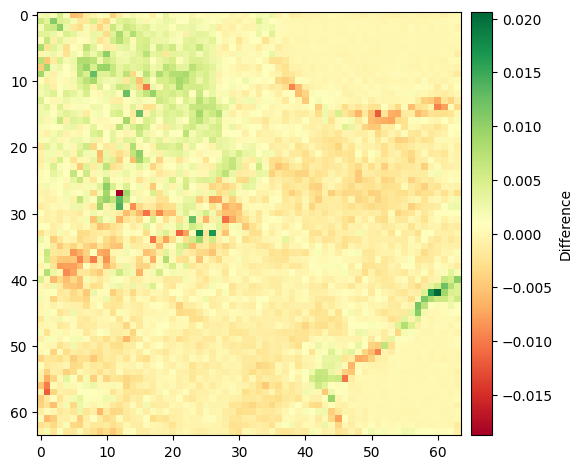

In [58]:
# Set up the subplot
fig, ax = plt.subplots()

i = 7
img = outputs[i, :, :] - outputs[i-1, :, :]
im = plt.imshow(img,  cmap='RdYlGn')

# Add a colorbar as a legend outside the chart
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Difference')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [6]:
import torch
print(torch.cuda.is_available())
print(f"GPU memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

True
GPU memory: 0.00 GB


In [36]:
from utils.function_clns import subsetting_pipeline, prepare, load_config

config = load_config(CONFIG_PATH)

dataset = prepare(subsetting_pipeline(CONFIG_PATH, 
                                      xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 
                                                                   "ndvi_smoothed_w2s.nc")),countries=args.country, regions=args.region))


ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [2]:
import xarray as xr
import os
from utils.function_clns import load_config, subsetting_pipeline
import numpy as np
import matplotlib.pyplot as plt
from analysis.deep_learning.GWNET.pipeline_gwnet import StandardScaler

#ndvi_scaler = StandardScaler(mean=0.21801364, std=0.13718395)

from utils.ndvi_functions import ndvi_colormap
cmap_ndvi, norm = ndvi_colormap()

from ancillary_vars.esa_landuse import drop_water_bodies_esa_downsample
mask_ds = drop_water_bodies_esa_downsample(ds.isel(time=0))
mask = torch.tensor(np.array(xr.where(mask_ds.notnull(), 1, 0)))

path = os.path.join(config_file["DEFAULT"]["output"],"predicted_ndvi_test.nc")

ds_pred = subsetting_pipeline(xr.open_dataset(path))["ndvi"]
ds_pred["time"] = (ds_pred["time"] + np.timedelta64(90, 'D'))
if args.normalize is True:
    ds_pred = ndvi_scaler.inverse_transform(ds_pred)

split = ds_pred.sizes["time"]
ds_sub = ds.sel(time=slice(ds_pred["time"].min(), ds_pred["time"].max()))
if args.normalize is True:
    ds_sub = ndvi_scaler.inverse_transform(ds_sub)

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes f

(array([   6.,    3.,   12.,  494., 1062.,  357.,  243.,  261.,  244.,
          90.]),
 array([-0.24514785, -0.15448742, -0.06382698,  0.02683346,  0.1174939 ,
         0.20815434,  0.29881477,  0.38947523,  0.48013565,  0.57079607,
         0.66145653]),
 <BarContainer object of 10 artists>)

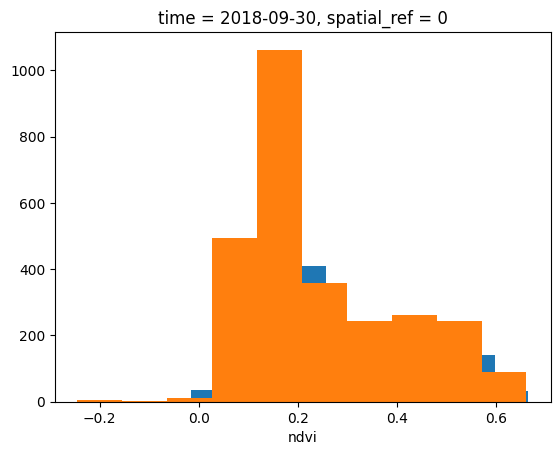

In [3]:
ds_pred.isel(time=0).plot.hist()
ds_sub.isel(time=0).plot.hist()

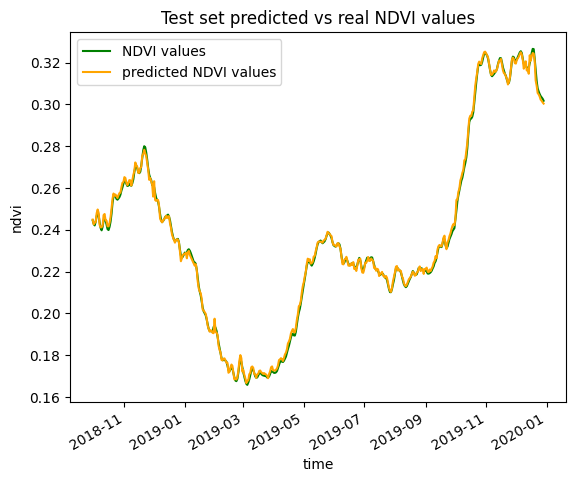

In [4]:
ds_sub.mean(["lat","lon"]).plot(label="NDVI values", color="green")
ds_pred.mean(["lat","lon"]).plot(label="predicted NDVI values", color="orange")
plt.title("Test set predicted vs real NDVI values")
plt.legend()

(array([8.00000e+00, 3.50000e+01, 4.30000e+01, 7.40000e+01, 8.20000e+01,
        7.80000e+01, 8.90000e+01, 8.50000e+01, 1.11000e+02, 1.51000e+02,
        5.72000e+02, 2.31500e+03, 5.69000e+03, 1.41580e+04, 2.74060e+04,
        3.67990e+04, 6.23560e+04, 1.01939e+05, 1.14688e+05, 1.01720e+05,
        8.88610e+04, 7.48070e+04, 6.26890e+04, 5.55220e+04, 5.09870e+04,
        4.59690e+04, 4.23380e+04, 3.96140e+04, 3.83090e+04, 3.62420e+04,
        3.39780e+04, 3.25080e+04, 3.08150e+04, 2.78260e+04, 2.53110e+04,
        2.19370e+04, 1.95540e+04, 1.68930e+04, 1.37650e+04, 1.12290e+04,
        9.27300e+03, 6.90100e+03, 4.49200e+03, 2.72200e+03, 1.33800e+03,
        5.82000e+02, 1.68000e+02, 7.80000e+01, 9.00000e+00, 4.00000e+00]),
 array([-0.23187093, -0.21223776, -0.1926046 , -0.17297143, -0.15333827,
        -0.13370509, -0.11407193, -0.09443876, -0.07480559, -0.05517242,
        -0.03553926, -0.01590609,  0.00372708,  0.02336024,  0.04299341,
         0.06262658,  0.08225975,  0.10189292,  0

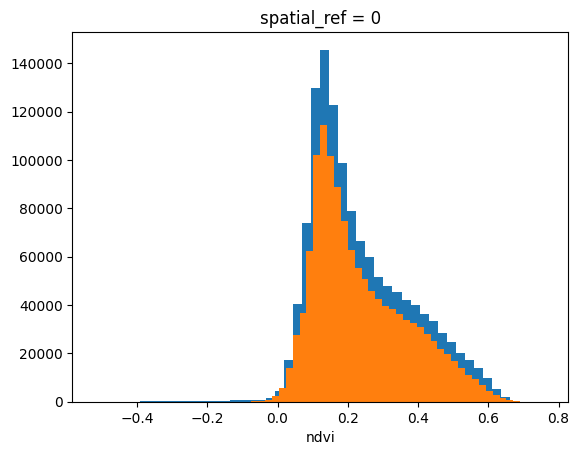

In [5]:
ds_sub.plot(bins=50)
ds_pred.plot(bins=50)

Text(0.5, 1.0, 'Test set Pearson correlation real vs predicted NDVI')

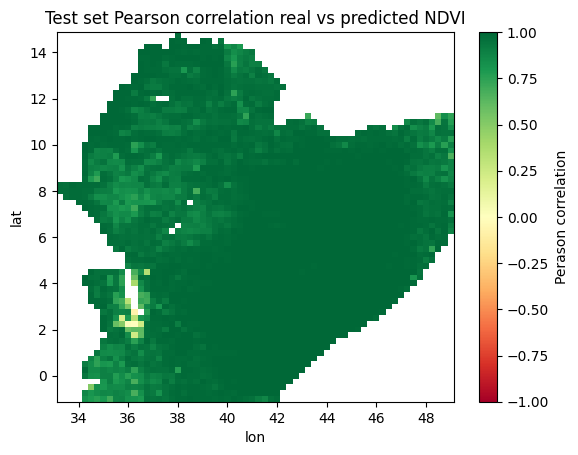

In [6]:
ds_sub = ds_sub.where(mask==1, np.NaN)
ds_pred = ds_pred.where(mask==1, np.NaN)
import xskillscore as xs
ax = xs.pearson_r(ds_sub, ds_pred, dim="time").plot(vmin=-1, vmax=1, cmap="RdYlGn")

# Access the colorbar from the FacetGrid object
cbar = ax.colorbar
cbar.set_label('Perason correlation')

plt.title("Test set Pearson correlation real vs predicted NDVI")



Text(0.5, 1.0, 'Test set RMSE real vs predicted NDVI')

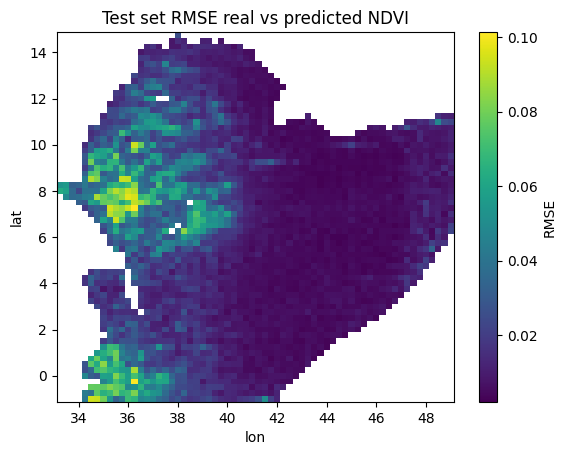

In [7]:
import xskillscore as xs
from xskillscore import Contingency

ax = xs.rmse(ds_sub, ds_pred, dim="time").plot()
# Access the colorbar from the FacetGrid object
cbar = ax.colorbar
cbar.set_label('RMSE')

plt.title("Test set RMSE real vs predicted NDVI")

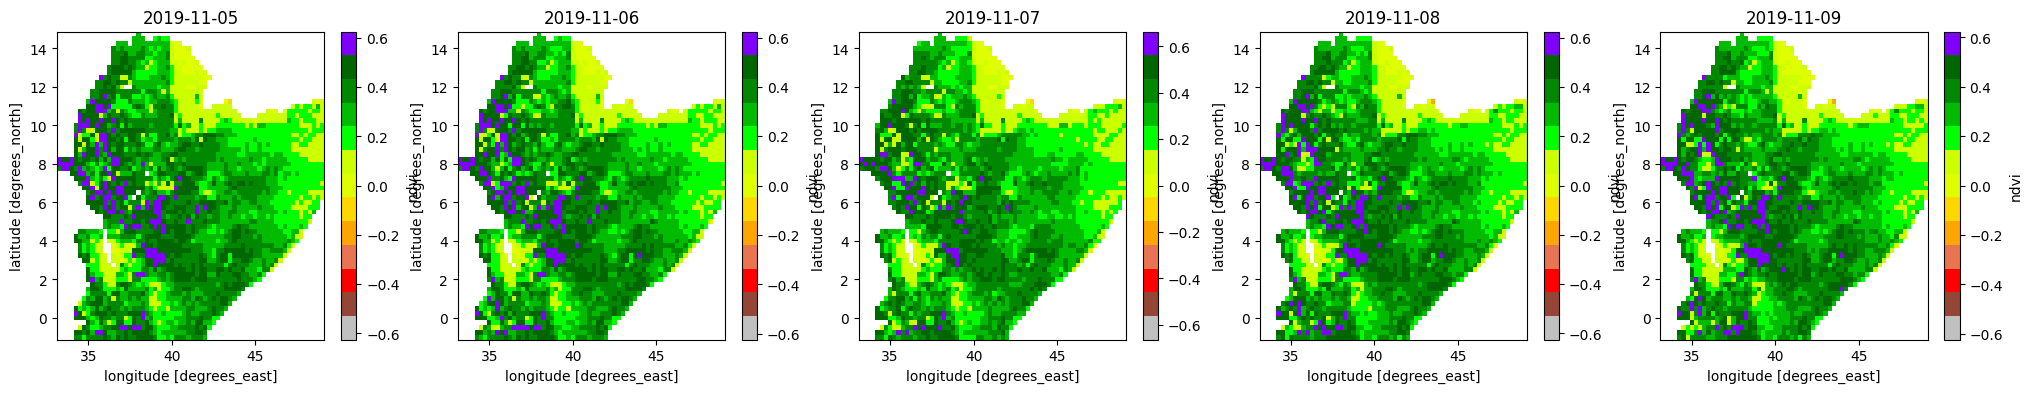

In [10]:
# Plotting in one row
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i in range(5):
    day = ds_sub.time.isel(time=401+i).dt.strftime('%Y-%m-%d').item()
    ds_sub.isel(time=402+i).plot(ax=axes[i], cmap=cmap_ndvi)
    axes[i].set_title(f'{day}')

plt.show()

In [14]:
sub_precp.var

<bound method DatasetAggregations.var of <xarray.Dataset>
Dimensions:              (lat: 64, lon: 64, time: 5478)
Coordinates:
  * lat                  (lat) float32 14.75 14.5 14.25 14.0 ... -0.5 -0.75 -1.0
  * lon                  (lon) float32 33.25 33.5 33.75 34.0 ... 48.5 48.75 49.0
  * time                 (time) datetime64[ns] 2005-01-01 ... 2019-12-31
    spatial_ref          int64 0
Data variables:
    total_precipitation  (time, lat, lon) float32 nan nan nan ... nan nan nan>

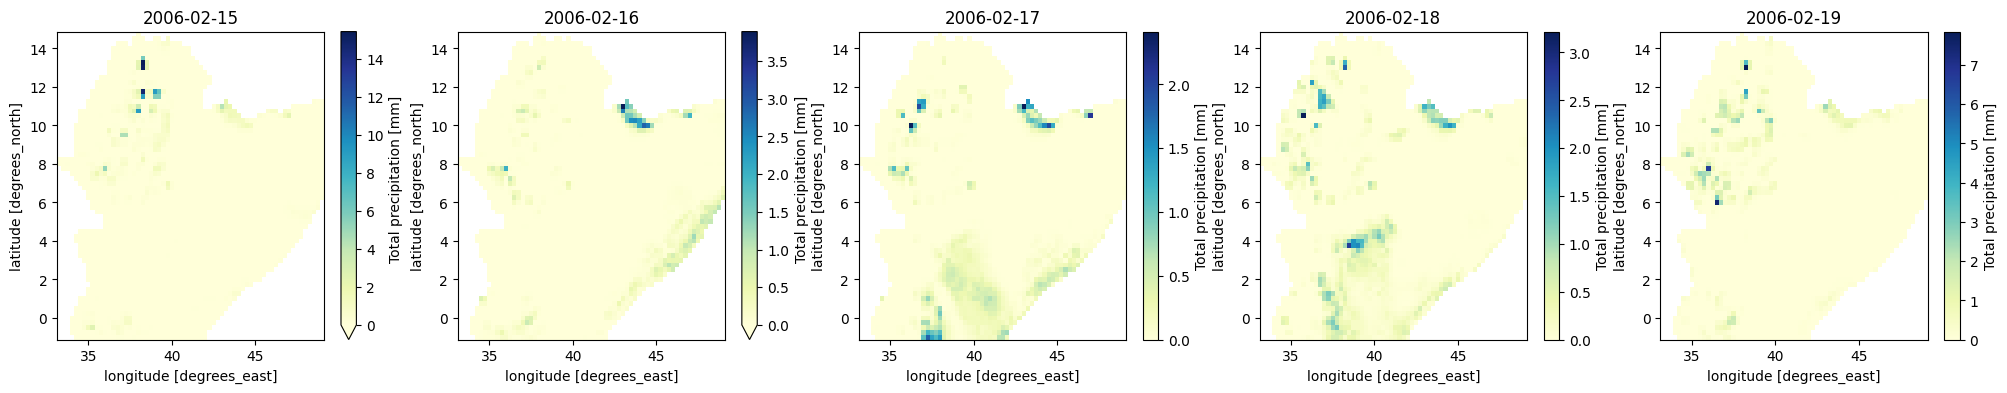

In [19]:
# Plotting in one row
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i in range(5):
    day = sub_precp["total_precipitation"].time.isel(time=410+i).dt.strftime('%Y-%m-%d').item()
    sub_precp["total_precipitation"].isel(time=402+i).plot(ax=axes[i], cmap="YlGnBu", vmin=0)
    axes[i].set_title(f'{day}')

plt.show()

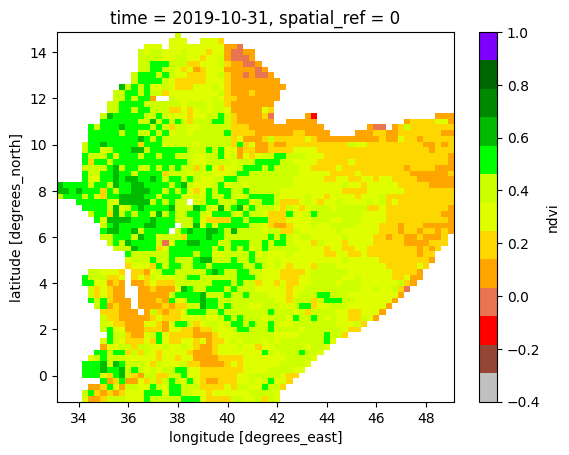

In [75]:
ds_sub.isel(time=396).plot(cmap = cmap_ndvi, vmin=-0.4, vmax=1)

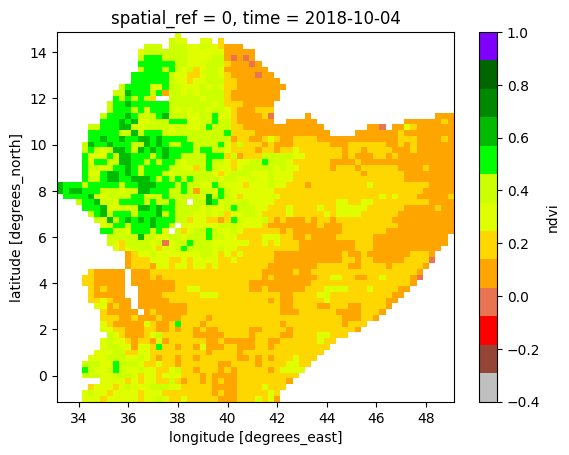

In [50]:
ds_pred.isel(time=4).plot(cmap = cmap_ndvi, vmin=-0.4, vmax=1)

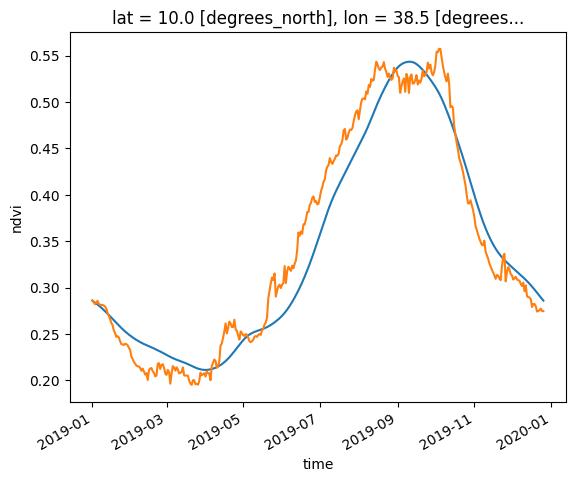

In [51]:
year = 2019
lat = 10
lon = 38.5

ds_sub.sel(time=ds_sub.time.dt.year == year).sel(lat = lat, lon = lon).plot()
ds_pred.sel(time=ds_pred.time.dt.year == year).sel(lat = lat, lon = lon).plot()

In [42]:
import subprocess
import os

import os

def restore_files_from_trash(file_name_pattern):
    trash_dir = os.path.expanduser("~/.local/share/Trash/files")  # Update the path as needed

    try:
        # List files in the trash directory
        trashed_files = [f for f in os.listdir(trash_dir) if os.path.isfile(os.path.join(trash_dir, f))]

        # Restore files matching the specified pattern
        for trashed_file in trashed_files:
            if file_name_pattern in trashed_file:
                source_path = os.path.join(trash_dir, trashed_file)
                destination_path = os.path.join(os.getcwd(), trashed_file)
                os.rename(source_path, destination_path)
                print(f"File '{trashed_file}' restored successfully.")

        print(f"Files matching '{file_name_pattern}' restored from trash.")
    except Exception as e:
        print(f"Error restoring files: {e}")

restore_files_from_trash("NDVImean")


Files matching 'NDVImean' restored from trash.


In [33]:
from utils.function_clns import config
import numpy as np
ds = xr.open_dataarray(os.path.join(config["NDVI"]["ndvi_path"], "ndvi_mean_seviri.nc"))

In [39]:
np.unique(ds["time"])

array(['2001-01-01T12:00:00.000000000'], dtype='datetime64[ns]')

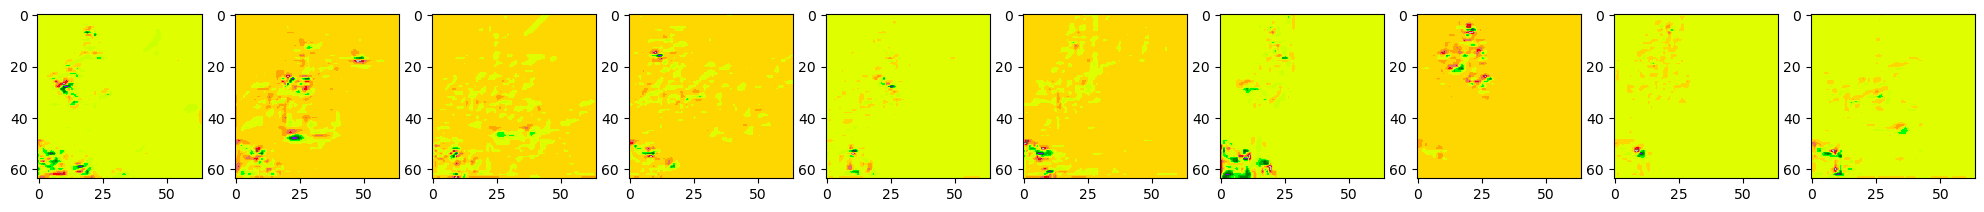

In [39]:
pics = 10compress

fig, axes = plt.subplots(1, pics, figsize=(5*5, 5))
for x in range(pics):
    #for n in range(pics, 0, -1):
    img = arr[x, :, :]
    axes[x].imshow(img, cmap= cmap_ndvi)
plt.show()

In [8]:
import xarray as xr
import os
from p_drought_indices.functions.function_clns import load_config, subsetting_pipeline

CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
path = os.path.join(config["SPI"]["ERA5"]["path"], "era5_total_precipitation_gc.nc")
ds = xr.open_dataset(path)
subsetting_pipeline(CONFIG_PATH, ds).isel(time=0)["total_precipitation"].plot()

In [ ]:
for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    print("single x shape: {}", x.shape)
    testx = torch.Tensor(x).to(device)
    testx = testx.transpose(1,3)
    with torch.no_grad():
        preds = engine.model(testx).transpose(1,3)
        print("single testx shape: {}", testx.shape)
        print("single prediction shape: {}", preds.shape)
        print("squeezed pred dims is: {}", preds.squeeze().shape)
        outputs.append(preds[:,0,:,:].squeeze())
        
yhat = torch.cat(outputs,dim=0)
yhat = yhat[:realy.size(0),...]

In [5]:
for i in range(args.seq_length):
    pred = scaler.inverse_transform(yhat[:,:,i])
    real = realy[:,:,i]
    print(pred.shape)
    print(real.shape)
    print(pred[0].shape)
    base_path = os.path.join(args.output_dir, "predicted_data")
    ds = get_predicted_dataset(pred, dates, sub_cols)
    ds.to_netcdf(os.path.join(base_path, f"predicted_ndvi_{i}.nc"))

torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])


In [2]:
import xarray as xr
import os
import numpy as np
from p_drought_indices.functions.function_clns import load_config, subsetting_pipeline
from datetime import datetime
import pandas as pd

CONFIG_PATH= "../config.yaml"
config_file = load_config(CONFIG_PATH)

In [22]:
import pandas as pd
from datetime import timedelta, datetime
from tqdm.auto import tqdm
from p_drought_indices.precipitation.data_collection.era5_daily_data import ee_collection
import xarray as xr
import os
from p_drought_indices.functions.function_clns import load_config, subsetting_pipeline

CONFIG_PATH= "../config.yaml"
config = load_config(CONFIG_PATH)

for day in tqdm(missing_days):
    print(f"Collecting day {day}...")
    new_day = pd.to_datetime(day) + timedelta(days=1)
    end_day = new_day.strftime("%Y-%m-%d")
    ee_collection(day, end_day)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:12<02:15, 12.28s/it]

 17%|█▋        | 2/12 [00:25<02:10, 13.03s/it]

 25%|██▌       | 3/12 [00:38<01:55, 12.83s/it]

 33%|███▎      | 4/12 [00:50<01:39, 12.43s/it]

 42%|████▏     | 5/12 [01:02<01:25, 12.19s/it]

 50%|█████     | 6/12 [01:14<01:13, 12.20s/it]

 58%|█████▊    | 7/12 [01:26<01:01, 12.25s/it]

 67%|██████▋   | 8/12 [01:37<00:47, 11.90s/it]

 75%|███████▌  | 9/12 [01:49<00:35, 11.82s/it]

 83%|████████▎ | 10/12 [01:59<00:22, 11.40s/it]

 92%|█████████▏| 11/12 [02:11<00:11, 11.49s/it]

100%|██████████| 12/12 [02:23<00:00, 11.94s/it]


In [2]:
from p_drought_indices.precipitation.data_collection.era5_daily_data import convert_tif_netcdf

base_path = config_file["SPI"]["ERA5"]["path"]
dest_path = os.path.join(base_path,"era5_netcdf")
path = os.path.join(base_path,"daily")

#convert_tif_netcdf(CONFIG_PATH, base_path, path, dest_path, use_gdal=True, compress=True)

In [3]:
import pandas as pd
path = os.path.join(base_path, "era5_land_merged.nc")
precp_ds = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(path))
### generate mask and count days  smaller than 0
mask = precp_ds['tp'] < 0
arr = mask.sum(dim=["lat","lon"])
print("Days with errors:", len(np.where(arr>0)[0]))
list_arr = np.where(arr>0)[0]
days = [np.datetime_as_string(precp_ds.isel(time=i)["time"].values, unit="D") for i in list_arr]
ds = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(base_path, "era5_precp_batch.nc"), chunks={"time":"200MB" }))
print("Collected days from ee:", len( np.unique(ds["time"].values)))

Days with errors: 1072
Collected days from ee: 1072


In [8]:
from p_drought_indices.functions.function_clns import prepare

ds = subsetting_pipeline(CONFIG_PATH, xr.open_dataset(os.path.join(base_path, 
    "era5_precp_batch.nc"), chunks={"time":"200MB" }))
res_ds = prepare(ds)["tp"].rio.reproject_match(prepare(precp_ds)["tp"]) \
    .rename({"y":"lat", "x":"lon"})
days_dt = [np.datetime64(f) for f in days]
ds_1 = precp_ds.drop_sel(time = days_dt) 
ds_ = xr.concat([ds_1, res_ds.to_dataset()], dim="time")
ds_ = ds_.sortby("time")

In [40]:
ds_.to_netcdf(os.path.join(base_path,"era5_land_merged_corr.nc"))

In [44]:
# Compute a boolean mask for missing values
missing_mask = xr.where(np.isnan(ds_["tp"]), True, False)

# Collapse the time dimension to check if the mask values are constant over time
are_missing_values_constant = missing_mask.all(dim='time')

# Print the result
print(are_missing_values_constant)

<xarray.DataArray 'tp' (lat: 195, lon: 183)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 51.0 51.1 51.2 51.3
  * lat          (lat) float32 14.8 14.7 14.6 14.5 14.4 ... -4.3 -4.4 -4.5 -4.6
    spatial_ref  int32 0


In [12]:
from p_drought_indices.analysis.DeepLearning.pipeline_gwnet import data_preparation
from p_drought_indices.functions.function_clns import load_config

CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
sub_precp, ds =  data_preparation(CONFIG_PATH, precp_dataset="CHIRPS")

The CHIRPS raster has spatial dimensions: (0.25, -0.25)
NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
Precipitation dataset resolution (0.25, -0.25)


In [ ]:
from p_drought_indices.functions.function_clns import load_config
from p_drought_indices.analysis.visualizations.viz_vci_spi import plot_veg_event
import os
import xarray as xr
CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)

path = config["PRECIP"]["ERA5_land"]["path"]
output_dir = os.path.join(path,  "graph_net/predicted_data")

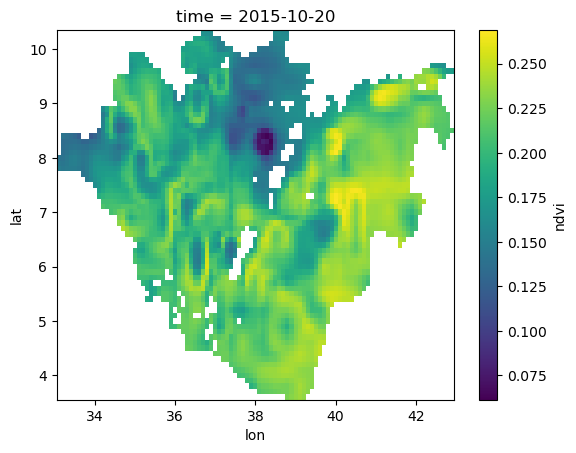

In [ ]:
ds = xr.open_dataset(os.path.join(output_dir, "predicted_ndvi_1.nc"))
ds.isel(time=0)["ndvi"].plot()

days are 366
Calculating the full year for boxplot
The days are 366
days are 365
For year 2017 obtaining only months 1 to 5 for boxplot


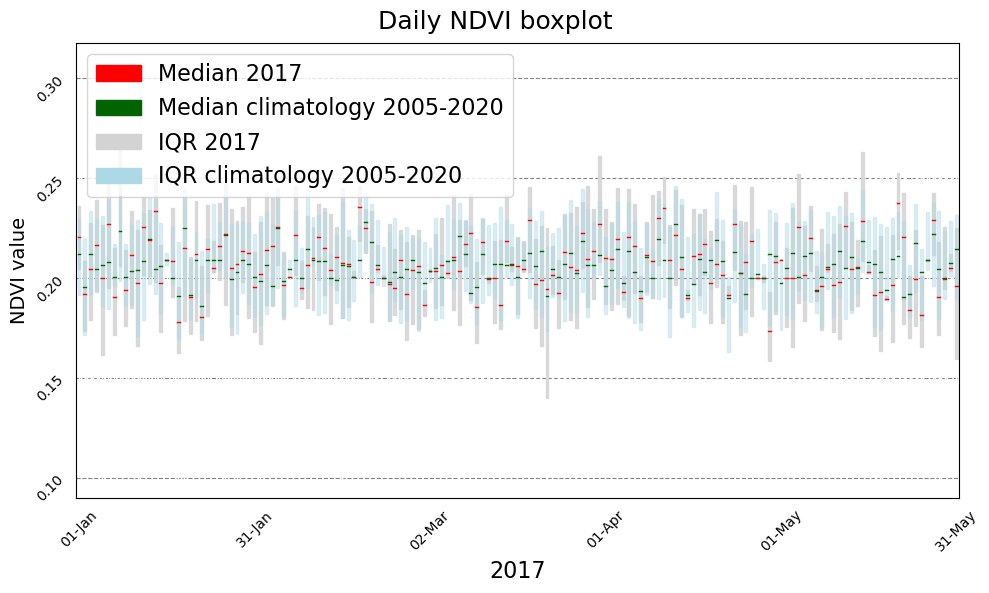

In [84]:
months = [i for i in np.arange(1,6)]
plot_veg_event(ds,year=2017, months=months)

In [2]:
from p_drought_indices.analysis.DeepLearning.GWNET.pipeline_gwnet import data_preparation, check_xarray_dataset
import pickle
import os
import matplotlib.pyplot as plt
from p_drought_indices.functions.function_clns import load_config
import numpy as np
from p_drought_indices.configs.config_3x3_16_3x3_32_3x3_64 import config
import torch
import pandas as pd

product = "ERA5_land"
CONFIG_PATH = "../config.yaml"
config_file = load_config(CONFIG_PATH)

c:\Users\Riccardo\Desktop\Other\package\Indices_analysis\notebooks\.


In [4]:
class Args:
    def __init__(self):
        self.device = 'cuda'
        self.adjtype = 'doubletransition'
        self.gcn_bool = False
        self.aptonly = False
        self.addaptadj = False
        self.randomadj = False
        self.nhid = 32
        self.in_dim = 1
        self.batch_size = config_file["GWNET"]["batch_size"]
        self.learning_rate = 0.001
        self.dropout = 0.3
        self.weight_decay = 0.0001
        self.print_every = 50
        self.expid = 1
        self.latency = 90
        self.spi = False
        self.precp_product = product
        self.forecast = 12
        self.seq_length = 12
        self.country = ["Kenya", "Ethiopia", "Somalia"]
        self.region = None
        self.dim = config_file["GWNET"]["pixels"]
        self.convlstm = True

# Create an instance of the Args class
args = Args()

from p_drought_indices.analysis.DeepLearning.GWNET.pipeline_gwnet import load_adj, MetricsRecorder, trainer,get_dataloader, data_preparation
from p_drought_indices.analysis.DeepLearning.GWNET.predictions_gwnet import get_predicted_dataset
path = config_file["PRECIP"]["ERA5_land"]["path"]
args.output_dir = os.path.join(path,  "graph_net")
checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.forecast}")
model_path = [os.path.join(checkp_path, f) for f in os.listdir(checkp_path) if "best" in f][0]

sub_precp, ds =  data_preparation(args, CONFIG_PATH, precp_dataset=args.precp_product)
#print("Checking precipitation dataset...")
#check_xarray_dataset(args, sub_precp, save=True)
#print("Checking vegetation dataset...")
#check_xarray_dataset(args, ds, save=True)

#dataloader, num_nodes, x_df = get_dataloader(args, CONFIG_PATH, sub_precp, ds, check_matrix=True)

2023-10-02 at 16:44:22 | INFO ℹ️ | Starting NDVI prediction with product ERA5_land with 12 days of features...
2023-10-02 at 16:44:32 | INFO ℹ️ | The ERA5_land raster has spatial dimensions: (0.10000000419197502, -0.1000000004915847)
2023-10-02 at 16:45:24 | INFO ℹ️ | MSG NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
2023-10-02 at 16:45:24 | INFO ℹ️ | ERA5_land precipitation dataset resolution: (0.10000000419197502, -0.1000000004915847)


Selecting data for ConvLSTM


IndexError: index 257 is out of bounds for axis 0 with size 195

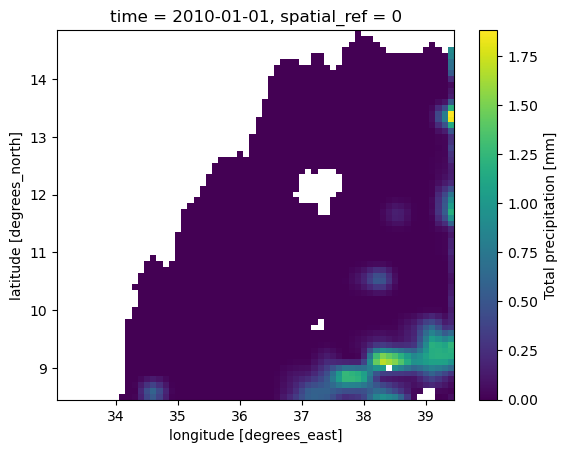

In [8]:
sub_precp.isel(time=0).plot()

lat-axis values: [14.8 14.7 14.6 14.5 14.4 14.3 14.2 14.1 14.  13.9 13.8 13.7 13.6 13.5
 13.4 13.3 13.2 13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1
 12.  11.9 11.8 11.7 11.6 11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7
 10.6 10.5 10.4 10.3 10.2 10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3
  9.2  9.1  9.   8.9  8.8  8.7  8.6  8.5]
lon-axis values: [33.1 33.2 33.3 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4
 34.5 34.6 34.7 34.8 34.9 35.  35.1 35.2 35.3 35.4 35.5 35.6 35.7 35.8
 35.9 36.  36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 37.  37.1 37.2
 37.3 37.4 37.5 37.6 37.7 37.8 37.9 38.  38.1 38.2 38.3 38.4 38.5 38.6
 38.7 38.8 38.9 39.  39.1 39.2 39.3 39.4]
Dimensions: ('time', 'lat', 'lon')
Size: 14958592
Number of Dimensions: 3
Shape: (3652, 64, 64)
Coordinates: Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 39.1 39.2 39.3 39.4
  * lat          (lat) float32 14.8 14.7 14.6 14.5 14.4 ... 8.9 8.8 8.7 8.6 8.5
  * time         (time) datetime

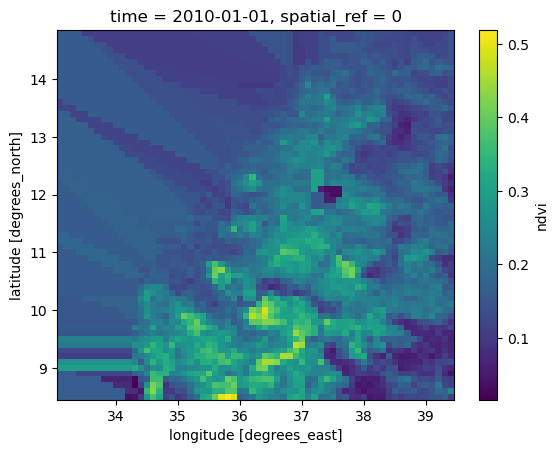

lat-axis values: [14.8 14.7 14.6 14.5 14.4 14.3 14.2 14.1 14.  13.9 13.8 13.7 13.6 13.5
 13.4 13.3 13.2 13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1
 12.  11.9 11.8 11.7 11.6 11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7
 10.6 10.5 10.4 10.3 10.2 10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3
  9.2  9.1  9.   8.9  8.8  8.7  8.6  8.5]
lon-axis values: [33.1 33.2 33.3 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4
 34.5 34.6 34.7 34.8 34.9 35.  35.1 35.2 35.3 35.4 35.5 35.6 35.7 35.8
 35.9 36.  36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 37.  37.1 37.2
 37.3 37.4 37.5 37.6 37.7 37.8 37.9 38.  38.1 38.2 38.3 38.4 38.5 38.6
 38.7 38.8 38.9 39.  39.1 39.2 39.3 39.4]
Dimensions: ('time', 'lat', 'lon')
Size: 14958592
Number of Dimensions: 3
Shape: (3652, 64, 64)
Coordinates: Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 39.1 39.2 39.3 39.4
  * lat          (lat) float32 14.8 14.7 14.6 14.5 14.4 ... 8.9 8.8 8.7 8.6 8.5
  * time         (time) datetime

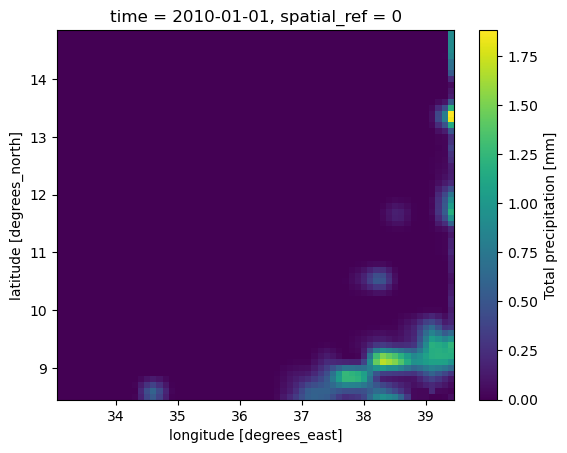

In [10]:
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_split, interpolate_prepare

#sub_precp = sub_precp.to_dataset()
data, target = interpolate_prepare(args, sub_precp.to_dataset(), ds)

In [12]:
train_split = 0.8
train_data, test_data, train_label, test_label = CNN_split(data, target, 
                                                               split_percentage=train_split)

batch_size = config_file["CONVLSTM"]["batch_size"]
# create a CustomDataset object using the reshaped input data
train_dataset = CustomDataset(train_data, train_label)
test_dataset = CustomDataset(test_data, test_label)
# create a DataLoader object that uses the dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
for batch_idx, (inputs, targets) in enumerate(test_dataloader):
    with torch.no_grad():
        inputs = inputs.float().to(config.device)
        targets = targets.float().to(config.device)
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())

NameError: name 'CustomDataset' is not defined

In [3]:
dates = x_df.index
cols = x_df.columns
sub_cols = [ (i[1], i[2]) for i in cols]
epochs = config_file["GWNET"]["epochs"]
dim = args.dim

device = torch.device(args.device)
adj_path = os.path.join(os.path.join(args.output_dir,  "adjacency_matrix"), f"{args.precp_product}_{args.dim}_adj_dist.pkl")
adj_mx = load_adj(adj_path,  args.adjtype)
scaler = dataloader['scaler']
supports = [torch.tensor(i).to(device) for i in adj_mx]
metrics_recorder = MetricsRecorder()
if args.spi==True:
    checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.precp_product}_SPI_{args.latency}")
else:
    checkp_path = os.path.join(args.output_dir,  f"checkpoints/forecast_{args.forecast}")
if args.randomadj:
    adjinit = None
else:
    adjinit = supports[0]
if args.aptonly:
    supports = None
engine = trainer(scaler, args.in_dim, args.seq_length, num_nodes, args.nhid, args.dropout,
                     args.learning_rate, args.weight_decay, device, supports, args.gcn_bool, args.addaptadj,
                     adjinit)
model = engine.model.load_state_dict(torch.load(model_path))
outputs = []
realy = torch.Tensor(dataloader['y_test']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]
print("realy dims is: {}", realy.shape)

2023-09-22 at 19:06:50 | INFO ℹ️ | Starting NDVI prediction with product ERA5_land with 12 days of features...
2023-09-22 at 19:07:24 | INFO ℹ️ | The ERA5_land raster has spatial dimensions: (0.10000000419197502, -0.1000000004915847)
2023-09-22 at 19:09:46 | INFO ℹ️ | MSG NDVI dataset resolution: (0.043782177927351104, 0.04378217792735114)
2023-09-22 at 19:09:47 | INFO ℹ️ | ERA5_land precipitation dataset resolution: (0.10000000419197502, -0.1000000004915847)


Selecting data for GCNN WaveNet
Checking precipitation dataset...
lat-axis values: [14.8 14.7 14.6 14.5 14.4 14.3 14.2 14.1 14.  13.9 13.8 13.7 13.6 13.5
 13.4 13.3 13.2 13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1
 12.  11.9 11.8 11.7 11.6 11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7
 10.6 10.5 10.4 10.3 10.2 10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3
  9.2  9.1  9.   8.9  8.8  8.7  8.6  8.5]
lon-axis values: [33.1 33.2 33.3 33.4 33.5 33.6 33.7 33.8 33.9 34.  34.1 34.2 34.3 34.4
 34.5 34.6 34.7 34.8 34.9 35.  35.1 35.2 35.3 35.4 35.5 35.6 35.7 35.8
 35.9 36.  36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 37.  37.1 37.2
 37.3 37.4 37.5 37.6 37.7 37.8 37.9 38.  38.1 38.2 38.3 38.4 38.5 38.6
 38.7 38.8 38.9 39.  39.1 39.2 39.3 39.4]
Dimensions: ('time', 'lat', 'lon')
Size: 4485120
Number of Dimensions: 3
Shape: (1095, 64, 64)
Coordinates: Coordinates:
  * lon          (lon) float32 33.1 33.2 33.3 33.4 33.5 ... 39.1 39.2 39.3 39.4
  * lat          (lat) float32 14.8 14.7 14.6 1

2023-09-22 at 19:10:29 | INFO ℹ️ | The features have dimensions: (1095, 2531, 1)


    lat   lon      
tp  14.8  37.900002    0
    14.7  38.099998    0
          38.000000    0
          37.900002    0
    14.6  39.099998    0
                      ..
    8.5   34.500000    0
          34.400002    0
          34.299999    0
          34.200001    0
          34.099998    0
Length: 2531, dtype: int64
0


2023-09-22 at 19:12:01 | INFO ℹ️ | The instance have dimensions: (1095, 2531, 1)


      lat   lon      
ndvi  14.8  37.900002    0
      14.7  38.099998    0
            38.000000    0
            37.900002    0
      14.6  39.099998    0
                        ..
      8.5   34.500000    0
            34.400002    0
            34.299999    0
            34.200001    0
            34.099998    0
Length: 2531, dtype: int64
0


2023-09-22 at 19:12:02 | INFO ℹ️ | Using previously created adjacency matrix
2023-09-22 at 19:12:02 | INFO ℹ️ | x shape: (1072, 12, 2531, 1)
2023-09-22 at 19:12:02 | INFO ℹ️ | y shape: (1072, 12, 2531, 1)
2023-09-22 at 19:12:02 | INFO ℹ️ | train x: (766, 12, 2531, 1), y: (766, 12, 2531, 1)
2023-09-22 at 19:12:37 | INFO ℹ️ | val x: (110, 12, 2531, 1), y: (110, 12, 2531, 1)
2023-09-22 at 19:12:42 | INFO ℹ️ | test x: (219, 12, 2531, 1), y: (219, 12, 2531, 1)


realy dims is: {} torch.Size([219, 2531, 12])


In [ ]:
for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    print("single x shape: {}", x.shape)
    testx = torch.Tensor(x).to(device)
    testx = testx.transpose(1,3)
    with torch.no_grad():
        preds = engine.model(testx).transpose(1,3)
        print("single testx shape: {}", testx.shape)
        print("single prediction shape: {}", preds.shape)
        print("squeezed pred dims is: {}", preds.squeeze().shape)
        outputs.append(preds[:,0,:,:].squeeze())
        
yhat = torch.cat(outputs,dim=0)
yhat = yhat[:realy.size(0),...]

In [5]:
for i in range(args.seq_length):
    pred = scaler.inverse_transform(yhat[:,:,i])
    real = realy[:,:,i]
    print(pred.shape)
    print(real.shape)
    print(pred[0].shape)
    base_path = os.path.join(args.output_dir, "predicted_data")
    ds = get_predicted_dataset(pred, dates, sub_cols)
    ds.to_netcdf(os.path.join(base_path, f"predicted_ndvi_{i}.nc"))

torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])
torch.Size([219, 2531])
torch.Size([219, 2531])
torch.Size([2531])


In [5]:
import os
import numpy as np
path = r"C:\Users\Riccardo\Desktop\Other\package\Indices_analysis\data\precipitation\ERA5_land\graph_net\predicted_data\data"
pred =[]
real=[]
name = "_12_ERA5_land.pkl"

from p_drought_indices.analysis.DeepLearning.GWNET.pipeline_gwnet import load_pickle

yhat = load_pickle(os.path.join(path, "pred"+ name))
target = load_pickle(os.path.join(path, "target"+ name))

In [9]:
len(pred)

80592